In [1]:
# MovieLense
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
from pycleora import SparseMatrix

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


2024-11-28 13:35:24.928402: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-28 13:35:24.928941: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-28 13:35:24.931701: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-28 13:35:24.939138: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732797324.951957    8050 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732797324.95

## Hyperparameters - both for cleora and additional models

In [2]:
config = {
    # embedding computation
    "cleora_n_iter": 3,
    "cleora_dim": 1024,
    # dataset preparation
    "train_test_split": 0.2,
    "batch_size": 256,
    "test_batch_size": 1000,
    "epochs": [10],
    "alpha": [1e-4],
}

## Downloading the data

In [3]:
data_dir = "../data"

In [4]:
def get_data(ds_name="movielens/100k-ratings"):
    def genre_id_to_text(genre_ids):
        return [genres[id] for id in genre_ids]

    ds = tfds.load(
        name=ds_name,
        split="all",
        data_dir=data_dir,
    )
    df = tfds.as_dataframe(ds)

    for col in df.columns:
        if df[col].dtype == "object":
            df[col] = df[col].apply(
                lambda x: x.decode("utf-8") if isinstance(x, bytes) else x
            )

    genres = [
        "Action",
        "Adventure",
        "Animation",
        "Children",
        "Comedy",
        "Crime",
        "Documentary",
        "Drama",
        "Fantasy",
        "Film-Noir",
        "Horror",
        "IMAX",
        "Musical",
        "Mystery",
        "Romance",
        "Sci-Fi",
        "Thriller",
        "War",
        "Western",
        "unknown",
    ]
    df["genres_id"] = df["movie_genres"]
    df["movie_genres"] = df["movie_genres"].apply(genre_id_to_text)

    return df


In [79]:
data = get_data("movielens/1m-ratings")
data.head()


2024-11-28 13:54:27.897873: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


,bucketized_user_age,movie_genres,movie_id,movie_title,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,user_rating,user_zip_code,genres_id
0,35.0,"[Action, Drama]",3107,Backdraft (1991),977432193,True,130,18,technician/engineer,5.0,50021,"[0, 7]"
1,25.0,[Drama],2114,"Outsiders, The (1983)",965932967,False,3829,0,academic/educator,4.0,22307,[7]
2,18.0,"[Comedy, Sci-Fi]",256,Junior (1994),1012103552,False,1265,21,writer,1.0,49321,"[4, 15]"
3,18.0,"[Action, Horror]",1389,Jaws 3-D (1983),972004605,True,2896,14,sales/marketing,5.0,60073,"[0, 10]"
4,18.0,[Action],3635,"Spy Who Loved Me, The (1977)",961180111,True,5264,17,college/grad student,4.0,15217,[0]


In [80]:
data[data['movie_genres'].apply(lambda genres: 'War' in genres)]

,bucketized_user_age,movie_genres,movie_id,movie_title,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,user_rating,user_zip_code,genres_id


## Prepare the data for proper embeddings

In [40]:
df = pd.DataFrame(data, columns=['movie_id', 'movie_genres'])
gr = df.groupby('movie_id').aggregate({'movie_genres':'first'})['movie_genres'].apply(list).values

In [41]:
cleora_input = map(lambda x: ' '.join(x), gr)


### Train-Test split - used for evaluation of our methods - maybe not needed??

In [42]:

# Create Markov transition matrix for the hypergraph

# Only one column - complex::reflexive
mat = SparseMatrix.from_iterator(cleora_input, columns='complex::reflexive::movie')

# Look at entity ids in the matrix, corresponding to embedding vectors
print(mat.entity_ids)

# Initialize embedding vectors externally, using text, image, random vectors
# embeddings = ...

# Or use built-in random deterministic initialization
embeddings = mat.initialize_deterministically(config["cleora_dim"])



['Animation', 'Children', 'Comedy', 'Action', 'Adventure', 'Thriller', 'Drama', 'Crime', 'unknown', 'Fantasy', 'Mystery', 'Sci-Fi', 'Musical', 'Documentary', 'Romance', 'Film-Noir', 'Western', 'Horror']


In [43]:
# Perform Markov random walk, then normalize however many times we want

# The optimal number depends on the graph, typically between 3 and 7 yields good results
# lower values tend to capture co-occurrence, higher iterations capture substitutability in a context

for i in range(config['cleora_n_iter']):
    # Can propagate with a symmetric matrix as well, but left Markov is a great default
    embeddings = mat.left_markov_propagate(embeddings)
    # Normalize with L2 norm by default, for the embeddings to reside on a hypersphere. Can use standardization instead.
    embeddings /= np.linalg.norm(embeddings, ord=2, axis=-1, keepdims=True)

# We're done, here are our embeddings



# We can now compare our embeddings with dot product (since they are L2 normalized)


In [44]:
for entity, embedding in zip(mat.entity_ids, embeddings):
    print([entity], embedding)

['Animation'] [-0.03680998 -0.03929688  0.01946319 ...  0.01418324  0.03782271
 -0.04482287]
['Children'] [-0.03254931 -0.0309281   0.01892222 ...  0.02470952  0.03361189
 -0.04470835]
['Comedy'] [-0.0287205   0.0012538   0.02071522 ...  0.01748403 -0.00975244
 -0.03443126]
['Action'] [ 0.01545496 -0.03794621 -0.01528297 ...  0.0573974   0.02508895
 -0.05045561]
['Adventure'] [-0.01729417 -0.02607475 -0.0031722  ...  0.05726264  0.0454374
 -0.03969053]
['Thriller'] [ 0.01465705 -0.01921224 -0.00777297 ...  0.05987902 -0.02457983
 -0.05054711]
['Drama'] [-0.00501708 -0.00213299  0.01359305 ...  0.02466374 -0.01550719
 -0.05376783]
['Crime'] [ 0.00240613 -0.01726486  0.0113833  ...  0.06166572  0.00210246
 -0.06367391]
['unknown'] [-0.04097362 -0.04277103  0.05021684 ...  0.01333737 -0.04669421
  0.0111592 ]
['Fantasy'] [-0.02771545 -0.03211655  0.01296254 ...  0.03313251  0.04278801
 -0.04024064]
['Mystery'] [-0.02152389 -0.00387623  0.02004016 ...  0.04441435 -0.04196255
 -0.05733834]


In [45]:
embeddings_df = pd.DataFrame(embeddings, index=np.asanyarray(map(lambda x: x, mat.entity_ids)))

In [46]:
mat.entity_ids

['Animation',
 'Children',
 'Comedy',
 'Action',
 'Adventure',
 'Thriller',
 'Drama',
 'Crime',
 'unknown',
 'Fantasy',
 'Mystery',
 'Sci-Fi',
 'Musical',
 'Documentary',
 'Romance',
 'Film-Noir',
 'Western',
 'Horror']

In [47]:
embeddings_df.loc['Animation'].to_numpy()

array([-0.03680998, -0.03929688,  0.01946319, ...,  0.01418324,
        0.03782271, -0.04482287], dtype=float32)

In [48]:
arrays = [embeddings_df.loc[i].to_numpy() for i in mat.entity_ids]


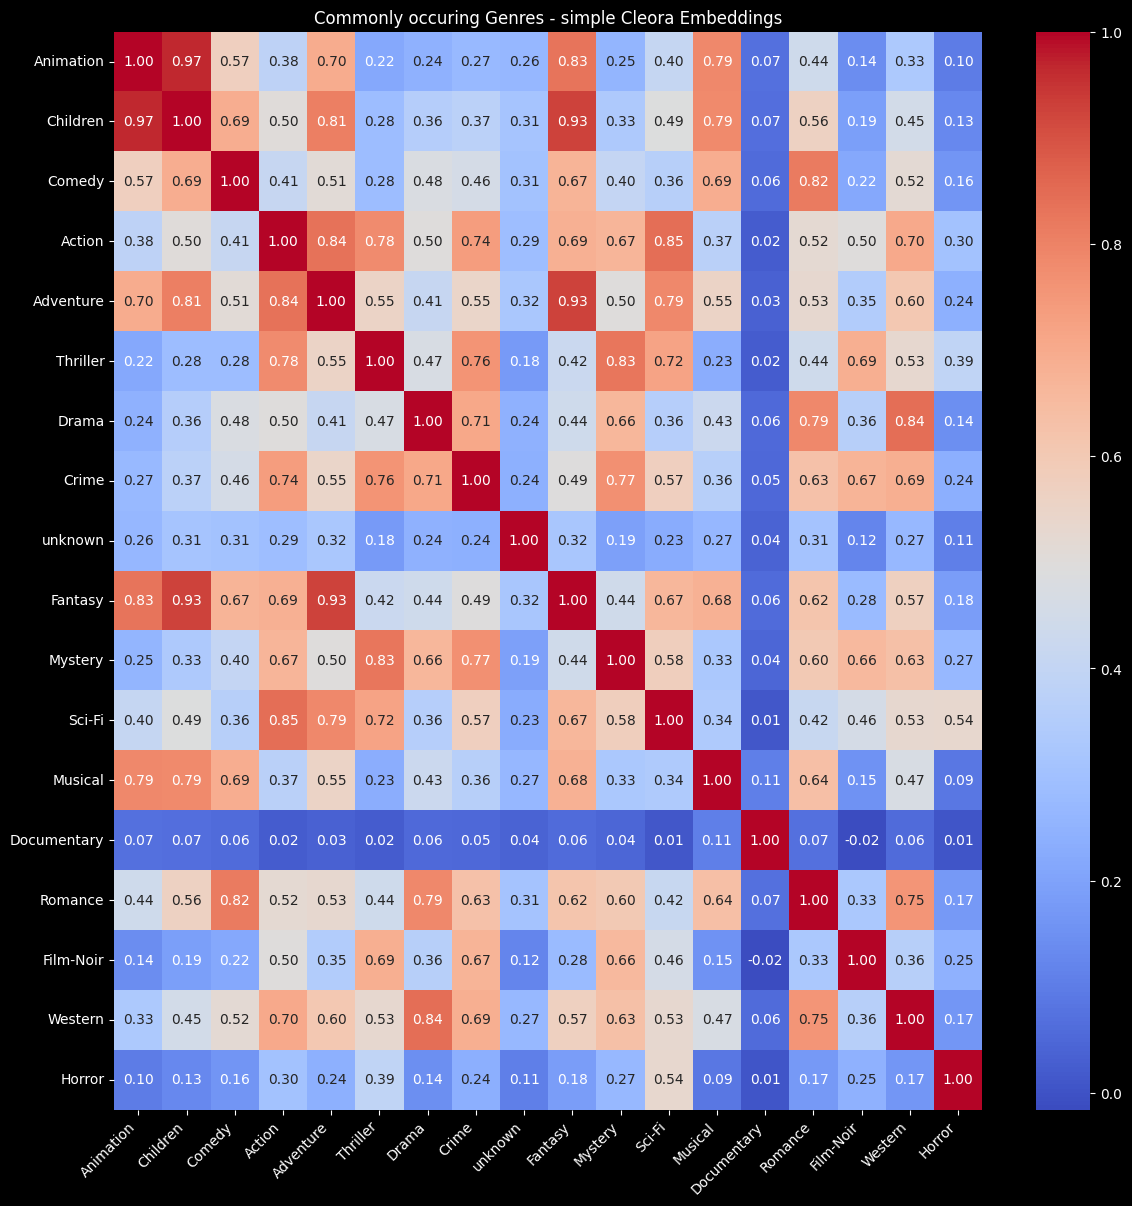

In [49]:
n = len(arrays)
dot_products = np.zeros((n, n))  

for i in range(n):
    for j in range(n):
        dot_products[i, j] = np.dot(arrays[i], arrays[j])

# Create a heatmap using Seaborn
plt.figure(figsize=(14, 14))
sns.heatmap(
    dot_products,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    xticklabels=mat.entity_ids,
    yticklabels=mat.entity_ids,
)
plt.xticks(rotation=45, ha='right')
plt.title("Commonly occuring Genres - simple Cleora Embeddings")
plt.show()